# 프로젝트 1 : 엘라스틱서치로 코로나데이터(200124~210907)분석
* 매핑정보 커스터마이징
* hash함수를 사용한 중복제거 로직만들기
* 가설을 세우고 결론까지 도출하기

In [1]:
from elasticsearch import Elasticsearch,helpers
from urllib import request
import os.path
import json 
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
es = Elasticsearch('http://localhost:9200/')

In [3]:
json_data = open('서울시 코로나19 확진자 현황.json','r',encoding='utf-8').read()
data = json.loads(json_data)
List = data['DATA']
List

[{'corona19_mdate': '2021-09-08 10:52:26',
  'corona19_travel_history': '',
  'corona19_corrective': None,
  'corona19_id': 83808,
  'corona19_leave_status': '-',
  'corona19_contact_history': '감염경로 조사중',
  'corona19_personal': None,
  'corona19_date': '2021-09-07',
  'corona19_area': '광진구',
  'corona19_idate': '2021-09-08 10:52:26',
  'corona19_display_yn': 'Y',
  'corona19_no': None,
  'corona19_country': None,
  'corona19_moving_path': None},
 {'corona19_mdate': '2021-09-08 10:52:26',
  'corona19_travel_history': '',
  'corona19_corrective': None,
  'corona19_id': 83807,
  'corona19_leave_status': '-',
  'corona19_contact_history': '감염경로 조사중',
  'corona19_personal': None,
  'corona19_date': '2021-09-07',
  'corona19_area': '동대문구',
  'corona19_idate': '2021-09-08 10:52:26',
  'corona19_display_yn': 'Y',
  'corona19_no': None,
  'corona19_country': None,
  'corona19_moving_path': None},
 {'corona19_mdate': '2021-09-08 10:52:26',
  'corona19_travel_history': '',
  'corona19_corrective'

## 1) 매핑정보 커스터마이징
### --> 기존 covid_index에서 자동으로 설정해준 매핑을 조금만 변경해 새 인덱스에 넣었습니다.
* text : 입력된 문자열을 term단위로 분리 --> 검색한 단어가 포함된 문자열에서 __의미있다고 판단되는 데이터만 가져옴__
* keyword : 입력된 문자열을 __분리하지 않고 하나의 term으로 저장__ --> 보통 aggs / sorting에 사용할 문자열 필드를 지정

In [ ]:
# 기존 covid_index의 자동매핑정보

{'covid_index': {'mappings': {'properties': {'corona19_area': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_contact_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_date': {'type': 'date'},
    'corona19_display_yn': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_id': {'type': 'long'},
    'corona19_idate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_leave_status': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_mdate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_travel_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}}}}}

#### 커스터마이징 변경
* ㉠ corona19_area(지역구) : text ---> keyword
* ㉡ corona19_contact_history(접촉력) : text유지(특정 단어를 검색했는데 완벽한 term이 아니면 리턴 안해주는 것 방지!)
* ㉢ corona19_id(연번) : long --> keyword
* ㉣ corona19_leave_status(상태) : text --> keyword
* ㉤ corona19_travel_history(여행력) : text유지(접촉력과 동일한 이유로 유지)

In [183]:
# 새로 커스터마이징한 매핑정보
mapping = {'mappings': {'properties': {'corona19_area': {'type': 'keyword'},
    'corona19_contact_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_date': {'type': 'date'},
    'corona19_display_yn': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_id': {'type': 'keyword'},
    'corona19_idate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_leave_status': {'type': 'keyword'},
    'corona19_mdate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_travel_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}}}}

In [187]:
es.indices.create(index='covid_index_2',body=mapping)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'covid_index_2'}

In [188]:
# 벌크 데이터 인덱스에 삽입
doc = []
for i in range(83808):
    doc.append({
        '_index' : 'covid_index_2',
        '_source' : List[i]
    })
helpers.bulk(es,doc)

(83808, [])

In [189]:
# 새로 얻은 매핑정보
es.indices.get_mapping(index='covid_index_2')

{'covid_index_2': {'mappings': {'properties': {'corona19_area': {'type': 'keyword'},
    'corona19_contact_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_date': {'type': 'date'},
    'corona19_display_yn': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_id': {'type': 'keyword'},
    'corona19_idate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_leave_status': {'type': 'keyword'},
    'corona19_mdate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_travel_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}}}}}

## 2) hash함수를 사용한 중복제거 로직만들기
* 월요일 중간점검때 지역구별 확진자/사망자/퇴원자 수를 확인했을때 "기타" 항목이 중복되어 검색되는 현상 발생
* --> 사실 csv파일엔 문제가 없었고 필터가 중복적용되었던 것....
* 그래도 중복값을 찾고 제거하는 방법에 대해 알아보기로 함

## hashlib 모듈
#### 검색에 많이 쓰인 필드 4개와 구분용 필드(ID)를 결합한 hash필드를 만들어 각 도큐먼트에 삽입
* json파일을 dataframe으로 변환 후 hashlib 모듈 적용했고, 이를 다시 json으로 변환해 새 인덱스에 삽입했습니다

In [224]:
# 데이터프레임화 한 후 hash_id가 있는 hash 필드 추가!
doc_df = []
for i in range(83808) : 
    doc_df.append(doc[i]['_source'])
df = pd.DataFrame(doc_df)
df['corona19_id'] = df['corona19_id'].astype('str')
df['hash'] = (df['corona19_travel_history']+df['corona19_area']+df['corona19_date']+df['corona19_contact_history']+df['corona19_leave_status']+df['corona19_id']).astype('str')
df['hash'] = df['hash'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

In [225]:
# 데이터프레임을 json으로 재변환
df.to_json('hash.json',orient='table')
json_data_hash = open('hash.json','r',encoding='utf-8').read()
hash_data = json.loads(json_data_hash)
test = hash_data['data']

In [226]:
hash_mapping = {'mappings': {'properties': {'corona19_area': {'type': 'keyword'},
    'corona19_contact_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_date': {'type': 'date'},
    'corona19_display_yn': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_id': {'type': 'keyword'},
    'corona19_idate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_leave_status': {'type': 'keyword'},
    'corona19_mdate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_travel_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'hash': {'type': 'keyword'}}}}

In [228]:
es.indices.create(index='hash_index',body=hash_mapping)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'hash_index'}

In [229]:
hash_doc = []
for i in range(83808):
    hash_doc.append({
        '_index' : 'hash_index',
        '_source' : test[i]
    })
helpers.bulk(es,hash_doc)

(83808, [])

In [230]:
es.indices.get_mapping(index='hash_index')

{'hash_index': {'mappings': {'properties': {'corona19_area': {'type': 'keyword'},
    'corona19_contact_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_date': {'type': 'date'},
    'corona19_display_yn': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_id': {'type': 'keyword'},
    'corona19_idate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_leave_status': {'type': 'keyword'},
    'corona19_mdate': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'corona19_travel_history': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'hash': {'type': 'keyword'},
    'index': {'type': 'long'}}}}}

In [231]:
# hashid 알아보기위한 테스트 진행
# 중복이 많았던 필드 2개를 필터링한뒤 검색해 3개의 결과 리턴
es.search(index='hash_index',body={
    'size' : 3,
    'query' : {
        'bool' : {
            'filter' : [{
            'term' : {
                'corona19_contact_history.keyword' : '감염경로 조사중'
            }
        },
            {'term' : {
                'corona19_area' : '강남구'
            }}]
        }
    }
})
# 069a3df9a99c07a72f88dc376c64ac2ecc90b54a572f75da843d43b6f8d1b6a1
# 7d82403951a8801f2524c3a5d4e82f71705acf7c46a4b690289f8ac828e27bbe
# bcd8ee151a30b0ccd87f0348a263631ecf57c6ba613feab9478d3036c849543e

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2168, 'relation': 'eq'},
  'max_score': 0.0,
  'hits': [{'_index': 'hash_index',
    '_type': '_doc',
    '_id': 'ftKe7XsBMoRywuuy_ZyJ',
    '_score': 0.0,
    '_source': {'index': 33,
     'corona19_mdate': '2021-09-08 10:52:26',
     'corona19_travel_history': '',
     'corona19_corrective': None,
     'corona19_id': '83775',
     'corona19_leave_status': '-',
     'corona19_contact_history': '감염경로 조사중',
     'corona19_personal': None,
     'corona19_date': '2021-09-07',
     'corona19_area': '강남구',
     'corona19_idate': '2021-09-08 10:52:26',
     'corona19_display_yn': 'Y',
     'corona19_no': None,
     'corona19_country': None,
     'corona19_moving_path': None,
     'hash': '069a3df9a99c07a72f88dc376c64ac2ecc90b54a572f75da843d43b6f8d1b6a1'}},
   {'_index': 'hash_index',
    '_type': '_doc',
    '_id': '79Ke7XsBMoRywuuy_ZyJ',
    '_score': 0.0,
    

# 3) 가설 세우고 결론까지 도출
### a. 강남구/영등포구/종로구 확진자들은 접촉력이 회사와 관련있지 않을까?
#### --> 회사와 관련있다면 집단감염일 확률이 높지 않을까?
### b. 타시도 확진자들은 접촉력이 의료시설과 관련있지 않을까?
#### --> 의료시설과 관련있다면 나이가 많아(추측) 사망률이 높지 않을까?
### c. 국가공휴일(광복절/추석/설....) 또는 연휴기간동안 확진자 수는?
#### --> 연휴기간동안에 지인 및 집회 관련 감염이 많지 않았을까?
### d. 강남구(대치동)/동작구(노량진)/양천구(목동)은 타 지역에 비해 학교/학원 관련 확진자가 많지 않을까?
### e. 해외유입 확진자수는 질병관리청에서 공지한 자료와 비슷한 양상을 보이는가?

### a. 강남구/영등포구/종로구 확진자들은 접촉력이 회사와 관련있지 않을까?
#### --> 회사와 관련있다면 집단감염일 확률이 높지 않을까?
* 회사/기업/센터 키워드로 3개 지역구 확진자 수 체크하고,
* 동일한 접촉력이 중복으로 5개 이상이면 '집단감염일것이다' 라고 가정
* 확진일이 비슷한 날짜면 가정이 맞음! (비슷한 날짜범위 : __1주일이내__)

* 강남구/영등포구/종로구 확진자 체크

In [46]:
gyj_inf = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'filter' : {
                'terms' : {
                'corona19_area' : ['강남구','영등포구','종로구']
            }
        }
    }
},
    'size' : 0,
    'aggs' : {
        '강남구/영등포구/종로구 확진자' : {
            'value_count' : {
                'field' : 'corona19_area'
            }
        } 
    }
})
gyj_inf   # 11023명

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': None,
  'hits': []},
 'aggregations': {'강남구/영등포구/종로구 확진자': {'value': 11023}}}

* 3개구의 회사,기업,센터 확진자 체크
* 원래는 회사/기업/센터를 한번에 filter & should쿼리로 묶어주려했으나 실패...
* msearch 메서드 사용(쿼리를 여러개 쏴주는 개념)

In [79]:
gyj_com_inf = es.msearch(body=[
    {'index' : 'covid_index_2'},
    {'query': {'bool':{'filter':[{'terms' : {'corona19_area':['강남구','영등포구','종로구']}},
                                 {'wildcard' : {'corona19_contact_history.keyword' : '*회사*'}}]}},
    'size':0,'aggs':{'3개구 회사 확진자' : {'value_count':{'field':'corona19_area'}}}},
    {'index' : 'covid_index_2'},
    {'query': {'bool':{'filter':[{'terms' : {'corona19_area':['강남구','영등포구','종로구']}},
                                 {'wildcard' : {'corona19_contact_history.keyword' : '*기업*'}}]}},
    'size':0,'aggs':{'3개구 기업 확진자' : {'value_count':{'field':'corona19_area'}}}},
    {'index' : 'covid_index_2'},
    {'query': {'bool':{'filter':[{'terms' : {'corona19_area':['강남구','영등포구','종로구']}},
                                 {'wildcard' : {'corona19_contact_history.keyword' : '*센터*'}}]}},
    'size':0,'aggs':{'3개구 센터 확진자' : {'value_count':{'field':'corona19_area'}}}},
])
for i in range(3) : 
    print(gyj_com_inf['responses'][i]['aggregations'])

{'3개구 회사 확진자': {'value': 40}}
{'3개구 기업 확진자': {'value': 7}}
{'3개구 센터 확진자': {'value': 16}}


* 중복 접촉력확인(지역필드는 강남/종로/영등포 로 고정시키고, 접촉력필드를 회사,기업,센터로 나눠서 적용)

In [94]:
# 회사 중복 확인
com_dup = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'filter' : [{
                'terms' : {
                    'corona19_area' : ['강남구','영등포구','종로구']
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*회사*'
                }
            }]
        }
    },
    'size' : 0,
    'aggs' : {
        '1' : {
            'terms' : {
                'field' : 'corona19_contact_history.keyword',
                'min_doc_count' : 5,
                'size' : 5
            },
            'aggs' : {
                '3개구 회사집단감염' : {
                    'value_count' : {
                        'field' : 'corona19_contact_history.keyword'
                    }
                }
            }
        }
    }
})
for i in range(4):
    print(com_dup['aggregations']['1']['buckets'][i]['key']," : ",com_dup['aggregations']['1']['buckets'][i]['doc_count']) 

강남구 소재 택시회사 관련  :  9
구로구 소재 보험회사 관련  :  8
경기 수원시 전자회사 관련  :  7
영등포구 증권회사 관련  :  5


* __중복 접촉력의 날짜도 비슷한가?__
* 강남구~ : 2020-12-25
*  구로구~ : 2020-12-02
* 수원시~ : 2021-08-02
* 영등포구~ : 2020-11-02

In [114]:
# 강남구 택시회사
es.search(index='covid_index_2',body={
        'query' : {
            'bool' : {
                'filter' : [{
                    'term' : {
                        'corona19_contact_history.keyword' : '강남구 소재 택시회사 관련'
                    }
                },
                {
                    'terms' : {
                        'corona19_area' : ['강남구','종로구','영등포구']
                    }
                }]
            }
        },
        'size' : 0,
        'aggs' : {
            '날짜체크' : {
                'range' : {
                'field' : 'corona19_date',
                'ranges' : [{
                    'from' : '2020-12-25',
                    'to' : '2021-01-01'
                }]
            } 
        }
    }
    })  # doc_count : 8개 --> 집단감염 맞음
# 날짜체크와 동일한 레벨에서 수행 

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 9, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'날짜체크': {'buckets': [{'key': '2020-12-25T00:00:00.000Z-2021-01-01T00:00:00.000Z',
     'from': 1608854400000.0,
     'from_as_string': '2020-12-25T00:00:00.000Z',
     'to': 1609459200000.0,
     'to_as_string': '2021-01-01T00:00:00.000Z',
     'doc_count': 8}]}}}

In [115]:
# 구로구 보험회사
es.search(index='covid_index_2',body={
        'query' : {
            'bool' : {
                'filter' : [{
                    'term' : {
                        'corona19_contact_history.keyword' : '구로구 소재 보험회사 관련'
                    }
                },
                {
                    'terms' : {
                        'corona19_area' : ['강남구','종로구','영등포구']
                    }
                }]
            }
        },
        'size' : 0,
        'aggs' : {
            '날짜체크' : {
                'range' : {
                'field' : 'corona19_date',
                'ranges' : [{
                    'from' : '2020-12-02',
                    'to' : '2020-12-09'
                }]
            } 
        }
    }
    })  # doc_count : 8개 --> 집단감염 맞음

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 8, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'날짜체크': {'buckets': [{'key': '2020-12-02T00:00:00.000Z-2020-12-09T00:00:00.000Z',
     'from': 1606867200000.0,
     'from_as_string': '2020-12-02T00:00:00.000Z',
     'to': 1607472000000.0,
     'to_as_string': '2020-12-09T00:00:00.000Z',
     'doc_count': 8}]}}}

In [116]:
# 수원시 전자회사
es.search(index='covid_index_2',body={
        'query' : {
            'bool' : {
                'filter' : [{
                    'term' : {
                        'corona19_contact_history.keyword' : '경기 수원시 전자회사 관련'
                    }
                },
                {
                    'terms' : {
                        'corona19_area' : ['강남구','종로구','영등포구']
                    }
                }]
            }
        },
        'size' : 0,
        'aggs' : {
            '날짜체크' : {
                'range' : {
                'field' : 'corona19_date',
                'ranges' : [{
                    'from' : '2021-08-02',
                    'to' : '2021-08-09'
                }]
            } 
        }
    }
    })  # doc_count : 7개 --> 집단감염 맞음

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 7, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'날짜체크': {'buckets': [{'key': '2021-08-02T00:00:00.000Z-2021-08-09T00:00:00.000Z',
     'from': 1627862400000.0,
     'from_as_string': '2021-08-02T00:00:00.000Z',
     'to': 1628467200000.0,
     'to_as_string': '2021-08-09T00:00:00.000Z',
     'doc_count': 7}]}}}

In [117]:
# 영등포구 증권회사
es.search(index='covid_index_2',body={
        'query' : {
            'bool' : {
                'filter' : [{
                    'term' : {
                        'corona19_contact_history.keyword' : '영등포구 증권회사 관련'
                    }
                },
                {
                    'terms' : {
                        'corona19_area' : ['강남구','종로구','영등포구']
                    }
                }]
            }
        },
        'size' : 0,
        'aggs' : {
            '날짜체크' : {
                'range' : {
                'field' : 'corona19_date',
                'ranges' : [{
                    'from' : '2020-11-02',
                    'to' : '2020-11-09'
                }]
            } 
        }
    }
    })  # doc_count : 5개 --> 집단감염 맞음

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 5, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'날짜체크': {'buckets': [{'key': '2020-11-02T00:00:00.000Z-2020-11-09T00:00:00.000Z',
     'from': 1604275200000.0,
     'from_as_string': '2020-11-02T00:00:00.000Z',
     'to': 1604880000000.0,
     'to_as_string': '2020-11-09T00:00:00.000Z',
     'doc_count': 5}]}}}

In [72]:
# 기업 중복 확인
es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'filter' : [{
                'terms' : {
                    'corona19_area' : ['강남구','영등포구','종로구']
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*기업*'
                }
            }]
        }
    },
    'size' : 0,
    'aggs' : {
        '1' : {
            'terms' : {
                'field' : 'corona19_contact_history.keyword',
                'min_doc_count' : 5,
                'size' : 5
            },
            'aggs' : {
                '3개구 기업집단감염' : {
                    'value_count' : {
                        'field' : 'corona19_contact_history.keyword'
                    }
                }
            }
        }
    }
})

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 7, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'1': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': '강남구 소재 공기업 관련',
     'doc_count': 6,
     '3개구 기업집단감염': {'value': 6}}]}}}

In [118]:
es.search(index='covid_index_2',body={
        'query' : {
            'bool' : {
                'filter' : [{
                    'term' : {
                        'corona19_contact_history.keyword' : '강남구 소재 공기업 관련'
                    }
                },
                {
                    'terms' : {
                        'corona19_area' : ['강남구','종로구','영등포구']
                    }
                }]
            }
        },
        'size' : 0,
        'aggs' : {
            '날짜체크' : {
                'range' : {
                'field' : 'corona19_date',
                'ranges' : [{
                    'from' : '2020-12-13',
                    'to' : '2020-12-20'
                }]
            } 
        }
    }
    })  # doc_count : 5개 --> 집단감염 맞음

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 6, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'날짜체크': {'buckets': [{'key': '2020-12-13T00:00:00.000Z-2020-12-20T00:00:00.000Z',
     'from': 1607817600000.0,
     'from_as_string': '2020-12-13T00:00:00.000Z',
     'to': 1608422400000.0,
     'to_as_string': '2020-12-20T00:00:00.000Z',
     'doc_count': 5}]}}}

In [73]:
# 센터 중복 확인
# alias 사용법 확인
es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'filter' : [{
                'terms' : {
                    'corona19_area' : ['강남구','영등포구','종로구']
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*센터*'
                }
            }]
        }
    },
    'size' : 0,
    'aggs' : {
        '1' : {
            'terms' : {
                'field' : 'corona19_contact_history.keyword',
                'min_doc_count' : 5,
                'size' : 5
            },
            'aggs' : {
                '3개구 센터집단감염' : {
                    'value_count' : {
                        'field' : 'corona19_contact_history.keyword'
                    }
                }
            }
        }
    }
})    # 중복값 없음

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 16, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'1': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': []}}}

### 결론 : 강남구/영등포구/종로구의 기업관련 확진자들의 집단감염 여부에 대한 가설은 기간 필터링 시
* 강남구 소재 택시회사 관련  :  9명 --> 8명
* 구로구 소재 보험회사 관련  :  8명 --> 8명
* 경기 수원시 전자회사 관련  :  7명 --> 7명
* 영등포구 증권회사 관련  :  5명 --> 5명
* 강남구 소재 공기업 관련 : 6명 --> 5명
### 의 적은 변동을 보여주어 채택되었습니다.

### b. 타시도 확진자들은 접촉력이 의료시설과 관련있지 않을까?
#### --> 의료시설과 관련있다면 나이가 많아(추측) 사망률이 높지 않을까?
* 타시도 확진자들중 의료시설관련 그룹의 사망률과
* 나머지 그룹 사망률 비교

* 타시도 확진자들의 접촉력 종류와 확진자 수 체크

In [158]:
num_check = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'filter' : {
            'term' : {
                'corona19_area' : '타시도'
            }
        }
    }
   },
    'size' : 0,
    'aggs' : {
        '접촉력 종류' : {
            'terms' : {
                'field' : 'corona19_contact_history.keyword'
            }
        }
    }
})  
num_check['aggregations']['접촉력 종류']['buckets']
# 감염경로 조사중 / 기타 확진자 접촉 / 타시도 확진자 접촉을 빼면 
# 병원 관련 비중이 높은 편!

[{'key': '감염경로 조사중', 'doc_count': 1596},
 {'key': '기타 확진자 접촉', 'doc_count': 905},
 {'key': '타시도 확진자 접촉', 'doc_count': 360},
 {'key': '병원 및 요양시설', 'doc_count': 83},
 {'key': '해외유입', 'doc_count': 44},
 {'key': '성북구 사랑제일교회 관련', 'doc_count': 36},
 {'key': '구로구 소재 요양병원/요양원 관련', 'doc_count': 30},
 {'key': '용산구 소재 병원 관련', 'doc_count': 26},
 {'key': "강남구 소재 직장 관련(\\'21.8.(4))", 'doc_count': 18},
 {'key': "강남구 소재 직장 관련(\\'21.7.)", 'doc_count': 13}]

* 타시도 확진자들의 전체 사망자 수 확인

In [237]:
death_num = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'filter' : [{
                'term' : {
                    'corona19_area' : '타시도'
                }
            },
            {
                'term' : {
                    'corona19_leave_status' : '사망'
                }
            }]
        }
    },
    'size' : 0,
    'aggs' : {
        '타시도 전체 사망자수' : {
            'value_count' : {
                'field' : 'corona19_leave_status'
            }
        }
    }
})
death_num['aggregations']   # 전체 사망자 수 42명

{'타시도 전체 사망자수': {'value': 42}}

* 타시도 확진자들 중 의료시설(병원/의료 키워드 포함)관련 사망자 수 확인

In [136]:
med_death_num = es.msearch(body=[
    {'index' : 'covid_index_2'},
    {'query' : {'bool' : {'filter' : [{'term' : {'corona19_area' : '타시도'}},{'term' : {'corona19_leave_status' : '사망'}},
                                     {'wildcard' : {'corona19_contact_history.keyword' : '*의료*'}}]}},
    'size' : 0,'aggs':{'타시도 의료 사망자수' : {'value_count':{'field' : 'corona19_leave_status'}}}},
    {'index' : 'covid_index_2'},
    {'query' : {'bool' : {'filter' : [{'term' : {'corona19_area' : '타시도'}},{'term' : {'corona19_leave_status' : '사망'}},
                                     {'wildcard' : {'corona19_contact_history.keyword' : '*병원*'}}]}},
    'size' : 0,'aggs':{'타시도 병원 사망자수' : {'value_count':{'field' : 'corona19_leave_status'}}}},
])
for i in range(2) : 
    print(med_death_num['responses'][i]['aggregations'])  # 총 14명

{'타시도 의료 사망자수': {'value': 1}}
{'타시도 병원 사망자수': {'value': 13}}


* 굳이 할 필요는 없었으나 학습을 위해 나머지 사망자 수도 구했습니다

In [140]:
other_death_num = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'must_not' : [{
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*의료*'
                }
            },
            {
                'wildcard' :{
                    'corona19_contact_history.keyword' : '*병원*'
                }
            }],
            'filter' : [{
                'term' : {
                    'corona19_area' : '타시도'
                }
            },
            {
                'term' : {
                    'corona19_leave_status' : '사망'
                }
            }]
        }
    },
    'size' : 0,
    'aggs' : {
        'other' : {
            'value_count' : {
                'field' : 'corona19_leave_status'
            }
        }
    }
})
other_death_num       # 28명

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 28, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'other': {'value': 28}}}

### 결론 : 타시도 확진자들 중 병원/의료 관련 그룹 사망률 : 14/42 = 33.3%
###    나머지 접촉력 사망률은 다 합쳐서 66.6%이기 때문에 의료 관련  확진자들의 사망률이 높다고 할 수 있음!

### c. 국가공휴일(광복절/추석/설....) 또는 연휴기간동안 확진자 수는?
#### --> 연휴기간동안에 집회 및 지인모임 관련 감염이 많지 않았을까?
* 국가공휴일 날짜범위지정(해당 날짜부터 +5일간의 확진자 수 집계)
* 연휴 기간인 경우 연휴기간 첫날부터 마지막날+5일간의 확진자 수 집계)
* 국가공휴일이 주말을 끼는 경우 주말 포함
* ---> ex) 2020년 추석 : 수--금 => 수요일~일요일까지 연휴기간 => 수요일부터 일요일+5일까지의 확진자 집계 
* 집계된 확진자 중 지인 및 집회관련 확진자 수 확인

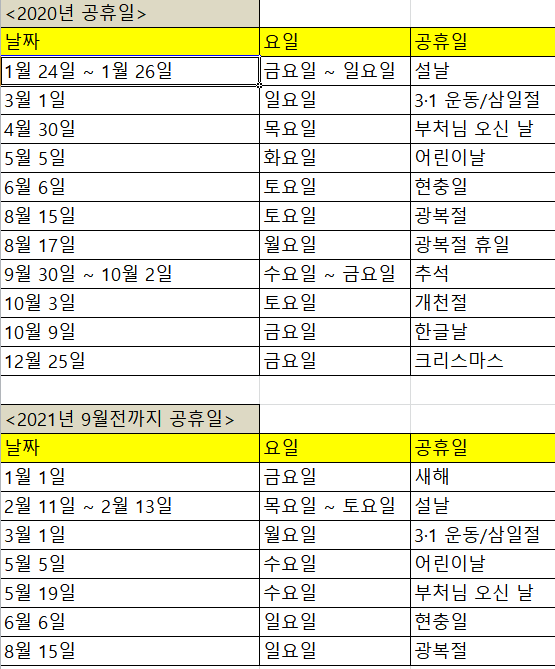

*  연휴기간 총 확진자 수 확인

In [238]:
holiday_inf_total = es.search(index='covid_index_2',body={
    'size' : 0,
    'aggs' : {
        '2020공휴일' :{
            'date_range' : {
                'field' : 'corona19_date',
                'ranges' : [
                    {'from' : '2020-01-24','to' : '2020-01-31'},
                    {'from' : '2020-03-01','to' : '2020-03-07'},
                    {'from' : '2020-04-30','to' : '2020-05-05'},
                    {'from' : '2020-05-05','to' : '2020-05-10'},
                    {'from' : '2020-06-06','to' : '2020-06-12'},
                    {'from' : '2020-08-15','to' : '2020-08-22'},
                    {'from' : '2020-09-30','to' : '2020-10-09'},
                    {'from' : '2020-10-09','to' : '2020-10-16'},
                    {'from' : '2020-12-25','to' : '2021-01-01'}
                ],
            }
        },
        '2021공휴일' : {
            'date_range' : {
                'field' : 'corona19_date',
                'ranges' : [
                    {'from' : '2021-01-01','to' : '2021-01-08'},
                    {'from' : '2021-02-11','to' : '2021-02-19'},
                    {'from' : '2021-02-27','to' : '2021-03-06'},
                    {'from' : '2021-05-05','to' : '2021-05-10'},
                    {'from' : '2021-05-19','to' : '2021-05-24'},
                    {'from' : '2021-06-05','to' : '2021-06-11'},
                    {'from' : '2021-08-14','to' : '2021-08-20'}
                ]
            }
        }
    }
})
holiday_inf_total

{'took': 6,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': None,
  'hits': []},
 'aggregations': {'2021공휴일': {'buckets': [{'key': '2021-01-01T00:00:00.000Z-2021-01-08T00:00:00.000Z',
     'from': 1609459200000.0,
     'from_as_string': '2021-01-01T00:00:00.000Z',
     'to': 1610064000000.0,
     'to_as_string': '2021-01-08T00:00:00.000Z',
     'doc_count': 1711},
    {'key': '2021-02-11T00:00:00.000Z-2021-02-19T00:00:00.000Z',
     'from': 1613001600000.0,
     'from_as_string': '2021-02-11T00:00:00.000Z',
     'to': 1613692800000.0,
     'to_as_string': '2021-02-19T00:00:00.000Z',
     'doc_count': 1376},
    {'key': '2021-02-27T00:00:00.000Z-2021-03-06T00:00:00.000Z',
     'from': 1614384000000.0,
     'from_as_string': '2021-02-27T00:00:00.000Z',
     'to': 1614988800000.0,
     'to_as_string': '2021-03-06T00:00:00.000Z',
     'doc_count': 826},
    {'key': '2021-05-05T

In [22]:
pd.options.display.float_format = '{:.2f}'.format
df = pd.DataFrame(holiday_inf_total['responses'][0]['aggregations']['2020공휴일']['buckets'])
df_2 = pd.DataFrame(holiday_inf_total['responses'][1]['aggregations']['2021공휴일']['buckets'])
df = pd.concat([df,df_2])
df['연휴명'] = ['설날','삼일절','석가탄신일','어린이날','현충일','광복절','추석','한글날','크리스마스',
             '새해','설날','삼일절','어린이날','부처님오신날','현충일','광복절']
df = df.drop(columns = ['from','from_as_string','to','to_as_string'])
df = df.rename(columns={'key' : '연휴기간','doc_count':'확진자 수'})
df = pd.DataFrame(df,columns=['연휴명','연휴기간','확진자 수'])
df

,연휴명,연휴기간,확진자 수
0,설날,2020-01-24T00:00:00.000Z-2020-01-31T00:00:00.000Z,4
1,삼일절,2020-03-01T00:00:00.000Z-2020-03-07T00:00:00.000Z,26
2,석가탄신일,2020-04-30T00:00:00.000Z-2020-05-05T00:00:00.000Z,4
3,어린이날,2020-05-05T00:00:00.000Z-2020-05-10T00:00:00.000Z,31
4,현충일,2020-06-06T00:00:00.000Z-2020-06-12T00:00:00.000Z,119
5,광복절,2020-08-15T00:00:00.000Z-2020-08-22T00:00:00.000Z,909
6,추석,2020-09-30T00:00:00.000Z-2020-10-09T00:00:00.000Z,192
7,한글날,2020-10-09T00:00:00.000Z-2020-10-16T00:00:00.000Z,166
8,크리스마스,2020-12-25T00:00:00.000Z-2021-01-01T00:00:00.000Z,2706
0,새해,2021-01-01T00:00:00.000Z-2021-01-08T00:00:00.000Z,1711


* 연휴기간 중 집회 및 지인모임 관련 확진자수 조사

In [239]:
holiday_inf_join = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'should' : [{
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*지인*'
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*집회*'
                }
            }]
        }
    },
    'size' : 0,
    'aggs' : {
        '2020 공휴일' : {
            'date_range' : {
                'field' : 'corona19_date',
                'ranges' : [
                    {'from' : '2020-01-24','to':'2020-01-31'},
                    {'from' : '2020-03-01','to' : '2020-03-07'},
                    {'from' : '2020-04-30','to' : '2020-05-05'},
                    {'from' : '2020-05-05','to' : '2020-05-10'},
                    {'from' : '2020-06-06','to' : '2020-06-12'},
                    {'from' : '2020-08-15','to' : '2020-08-22'},
                    {'from' : '2020-09-30','to' : '2020-10-09'},
                    {'from' : '2020-10-09','to' : '2020-10-16'},
                    {'from' : '2020-12-25','to' : '2021-01-01'}
                ]
            }
        },
        '2021 공휴일' : {
            'date_range' : {
                'field' : 'corona19_date',
                'ranges' : [
                    {'from' : '2021-01-01','to' : '2021-01-08'},
                    {'from' : '2021-02-11','to' : '2021-02-19'},
                    {'from' : '2021-02-27','to' : '2021-03-06'},
                    {'from' : '2021-05-05','to' : '2021-05-10'},
                    {'from' : '2021-05-19','to' : '2021-05-24'},
                    {'from' : '2021-06-05','to' : '2021-06-11'},
                    {'from' : '2021-08-14','to' : '2021-08-20'}
                ]
            }
        }
    }
})
holiday_inf_join

{'took': 8,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1148, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'2020 공휴일': {'buckets': [{'key': '2020-01-24T00:00:00.000Z-2020-01-31T00:00:00.000Z',
     'from': 1579824000000.0,
     'from_as_string': '2020-01-24T00:00:00.000Z',
     'to': 1580428800000.0,
     'to_as_string': '2020-01-31T00:00:00.000Z',
     'doc_count': 0},
    {'key': '2020-03-01T00:00:00.000Z-2020-03-07T00:00:00.000Z',
     'from': 1583020800000.0,
     'from_as_string': '2020-03-01T00:00:00.000Z',
     'to': 1583539200000.0,
     'to_as_string': '2020-03-07T00:00:00.000Z',
     'doc_count': 0},
    {'key': '2020-04-30T00:00:00.000Z-2020-05-05T00:00:00.000Z',
     'from': 1588204800000.0,
     'from_as_string': '2020-04-30T00:00:00.000Z',
     'to': 1588636800000.0,
     'to_as_string': '2020-05-05T00:00:00.000Z',
     'doc_count': 0},
    {'key': '2020-05-05T00:00:00.

* 연휴기간 중 집회/지인모임 관련이 아닌 확진자 수 조사

In [8]:
holiday_inf_nojoin = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'must_not' : [{
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*지인*'
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*집회*'
                }
            }]
        }
    },
    'size' : 0,
    'aggs' : {
        '2020 공휴일' : {
            'date_range' : {
                'field' : 'corona19_date',
                'ranges' : [
                    {'from' : '2020-01-24','to':'2020-01-31'},
                    {'from' : '2020-03-01','to' : '2020-03-07'},
                    {'from' : '2020-04-30','to' : '2020-05-05'},
                    {'from' : '2020-05-05','to' : '2020-05-10'},
                    {'from' : '2020-06-06','to' : '2020-06-12'},
                    {'from' : '2020-08-15','to' : '2020-08-22'},
                    {'from' : '2020-09-30','to' : '2020-10-09'},
                    {'from' : '2020-10-09','to' : '2020-10-16'},
                    {'from' : '2020-12-25','to' : '2021-01-01'}
                ]
            }
        },
        '2021 공휴일' : {
            'date_range' : {
                'field' : 'corona19_date',
                'ranges' : [
                    {'from' : '2021-01-01','to' : '2021-01-08'},
                    {'from' : '2021-02-11','to' : '2021-02-19'},
                    {'from' : '2021-02-27','to' : '2021-03-06'},
                    {'from' : '2021-05-05','to' : '2021-05-10'},
                    {'from' : '2021-05-19','to' : '2021-05-24'},
                    {'from' : '2021-06-05','to' : '2021-06-11'},
                    {'from' : '2021-08-14','to' : '2021-08-20'}
                ]
            }
        }
    }
})
holiday_inf_nojoin

{'took': 41,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': None,
  'hits': []},
 'aggregations': {'2020 공휴일': {'buckets': [{'key': '2020-01-24T00:00:00.000Z-2020-01-31T00:00:00.000Z',
     'from': 1579824000000.0,
     'from_as_string': '2020-01-24T00:00:00.000Z',
     'to': 1580428800000.0,
     'to_as_string': '2020-01-31T00:00:00.000Z',
     'doc_count': 4},
    {'key': '2020-03-01T00:00:00.000Z-2020-03-07T00:00:00.000Z',
     'from': 1583020800000.0,
     'from_as_string': '2020-03-01T00:00:00.000Z',
     'to': 1583539200000.0,
     'to_as_string': '2020-03-07T00:00:00.000Z',
     'doc_count': 26},
    {'key': '2020-04-30T00:00:00.000Z-2020-05-05T00:00:00.000Z',
     'from': 1588204800000.0,
     'from_as_string': '2020-04-30T00:00:00.000Z',
     'to': 1588636800000.0,
     'to_as_string': '2020-05-05T00:00:00.000Z',
     'doc_count': 4},
    {'key': '2020-05-05T00:00

* 데이터프레임으로 비교

In [50]:
df1 = pd.DataFrame(holiday_inf_join['aggregations']['2020 공휴일']['buckets'])
df2 = pd.DataFrame(holiday_inf_join['aggregations']['2021 공휴일']['buckets'])
join_df = pd.concat([df1,df2])
join_df['연휴명'] = ['설날','삼일절','석가탄신일','어린이날','현충일','광복절','추석','한글날','크리스마스',
             '새해','설날','삼일절','어린이날','부처님오신날','현충일','광복절']
join_df = join_df.drop(columns = ['from','from_as_string','to','to_as_string'])
join_df = join_df.rename(columns={'key' : '연휴기간','doc_count':'집회/모임 확진자 수'})
join_df = pd.DataFrame(join_df,columns=['연휴명','연휴기간','집회/모임 확진자 수'])

df3 = pd.DataFrame(holiday_inf_nojoin['aggregations']['2020 공휴일']['buckets'])
df4 = pd.DataFrame(holiday_inf_nojoin['aggregations']['2021 공휴일']['buckets'])
nojoin_df = pd.concat([df3,df4])
nojoin_df['연휴명'] = ['설날','삼일절','석가탄신일','어린이날','현충일','광복절','추석','한글날','크리스마스',
             '새해','설날','삼일절','어린이날','부처님오신날','현충일','광복절']
nojoin_df = nojoin_df.drop(columns = ['from','from_as_string','to','to_as_string'])
nojoin_df = nojoin_df.rename(columns={'key' : '연휴기간','doc_count':'기타 확진자 수'})
nojoin_df = pd.DataFrame(nojoin_df,columns=['연휴명','연휴기간','기타 확진자 수'])


final_df = pd.merge(join_df,nojoin_df,on='연휴기간',how='left')
final_df = final_df.drop(columns='연휴명_y')
final_df['총 확진자 수'] = final_df['집회/모임 확진자 수'] + final_df['기타 확진자 수']
final_df['집회/모임 비율(%)'] = final_df['집회/모임 확진자 수'] / final_df['총 확진자 수'] * 100
final_df

,연휴명_x,연휴기간,집회/모임 확진자 수,기타 확진자 수,총 확진자 수,집회/모임 비율(%)
0,설날,2020-01-24T00:00:00.000Z-2020-01-31T00:00:00.000Z,0,4,4,0.00
1,삼일절,2020-03-01T00:00:00.000Z-2020-03-07T00:00:00.000Z,0,26,26,0.00
2,석가탄신일,2020-04-30T00:00:00.000Z-2020-05-05T00:00:00.000Z,0,4,4,0.00
3,어린이날,2020-05-05T00:00:00.000Z-2020-05-10T00:00:00.000Z,0,31,31,0.00
4,현충일,2020-06-06T00:00:00.000Z-2020-06-12T00:00:00.000Z,0,119,119,0.00
5,광복절,2020-08-15T00:00:00.000Z-2020-08-22T00:00:00.000Z,37,872,909,4.07
6,추석,2020-09-30T00:00:00.000Z-2020-10-09T00:00:00.000Z,1,191,192,0.52
7,한글날,2020-10-09T00:00:00.000Z-2020-10-16T00:00:00.000Z,2,164,166,1.20
8,크리스마스,2020-12-25T00:00:00.000Z-2021-01-01T00:00:00.000Z,4,2702,2706,0.15
9,새해,2021-01-01T00:00:00.000Z-2021-01-08T00:00:00.000Z,1,1710,1711,0.06


* 생각보다 많지 않은 것 같습니다....!
* 그렇다면 동일 기간동안 가장 많은 접촉력은 무엇인지 확인

In [42]:
holiday_reason = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'must_not' : [{
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*지인*'
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*집회*'
                }
            },
            {
                'terms' : {
                    'corona19_contact_history.keyword' : ['감염경로 조사중','기타 확진자 접촉','타시도 확진자 접촉']
                }
            }]
        }
    },
    'size' : 0,
    'aggs' : {
        '2020 공휴일' : {
            'date_range' : {
                'field' : 'corona19_date',
                'ranges' : [
                    {'from' : '2020-01-24','to':'2020-01-31'},
                    {'from' : '2020-03-01','to' : '2020-03-07'},
                    {'from' : '2020-04-30','to' : '2020-05-05'},
                    {'from' : '2020-05-05','to' : '2020-05-10'},
                    {'from' : '2020-06-06','to' : '2020-06-12'},
                    {'from' : '2020-08-15','to' : '2020-08-22'},
                    {'from' : '2020-09-30','to' : '2020-10-09'},
                    {'from' : '2020-10-09','to' : '2020-10-16'},
                    {'from' : '2020-12-25','to' : '2021-01-01'}
                ]
            },
            'aggs' : {
                '2020 종류 체크' : {
                    'terms' : {
                        'field' : 'corona19_contact_history.keyword'
                    }
                }
            }
        },
        '2021 공휴일' : {
            'date_range' : {
                'field' : 'corona19_date',
                'ranges' : [
                    {'from' : '2021-01-01','to' : '2021-01-08'},
                    {'from' : '2021-02-11','to' : '2021-02-19'},
                    {'from' : '2021-02-27','to' : '2021-03-06'},
                    {'from' : '2021-05-05','to' : '2021-05-10'},
                    {'from' : '2021-05-19','to' : '2021-05-24'},
                    {'from' : '2021-06-05','to' : '2021-06-11'},
                    {'from' : '2021-08-14','to' : '2021-08-20'}
                ]
            },
            'aggs' : {
                '2021 종류 체크' : {
                    'terms' : {
                        'field' : 'corona19_contact_history.keyword'
                    }
                }
            }
        }
    }
})
holiday_reason

C:\Users\NSHC\anaconda3\lib\site-packages\elasticsearch\connection\base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.14/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


{'took': 6,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': None,
  'hits': []},
 'aggregations': {'2020 공휴일': {'buckets': [{'key': '2020-01-24T00:00:00.000Z-2020-01-31T00:00:00.000Z',
     'from': 1579824000000.0,
     'from_as_string': '2020-01-24T00:00:00.000Z',
     'to': 1580428800000.0,
     'to_as_string': '2020-01-31T00:00:00.000Z',
     'doc_count': 4,
     '2020 종류 체크': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      'buckets': [{'key': '해외유입', 'doc_count': 3},
       {'key': '종로구 집단발병', 'doc_count': 1}]}},
    {'key': '2020-03-01T00:00:00.000Z-2020-03-07T00:00:00.000Z',
     'from': 1583020800000.0,
     'from_as_string': '2020-03-01T00:00:00.000Z',
     'to': 1583539200000.0,
     'to_as_string': '2020-03-07T00:00:00.000Z',
     'doc_count': 12,
     '2020 종류 체크': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      '

In [43]:
reason2020 = []
for i in range(9) : 
    reason2020.append(holiday_reason['aggregations']['2020 공휴일']['buckets'][i]['2020 종류 체크']['buckets'][0])
reason2021 = []
for i in range(7) : 
    reason2021.append(holiday_reason['aggregations']['2021 공휴일']['buckets'][i]['2021 종류 체크']['buckets'][0])
reason_all = reason2020+reason2021
reason_all

[{'key': '해외유입', 'doc_count': 3},
 {'key': '성동구 아파트 관리사무소', 'doc_count': 6},
 {'key': '해외유입', 'doc_count': 4},
 {'key': '이태원 클럽 관련', 'doc_count': 29},
 {'key': '양천구운동시설', 'doc_count': 27},
 {'key': '성북구 사랑제일교회 관련', 'doc_count': 463},
 {'key': '도봉구 다나병원', 'doc_count': 21},
 {'key': '도봉구 다나병원', 'doc_count': 14},
 {'key': '동부구치소 관련', 'doc_count': 423},
 {'key': '동부구치소 관련', 'doc_count': 211},
 {'key': '용산구 소재 병원 관련', 'doc_count': 157},
 {'key': '영등포구 소재 음식점 관련', 'doc_count': 31},
 {'key': '강북구 소재 PC방 관련', 'doc_count': 27},
 {'key': "송파구 소재 시장 관련(\\'21.5.)", 'doc_count': 31},
 {'key': "송파구 소재 시장 관련(\\'21.5.)", 'doc_count': 23},
 {'key': '해외유입', 'doc_count': 38}]

In [51]:
df_reason = pd.DataFrame(reason_all)
final_df['최다 확진자 접촉력'] = df_reason['key']
final_df['환자수'] =  df_reason['doc_count']
final_df = final_df.drop(columns=['기타 확진자 수','집회/모임 비율(%)'])
final_df

,연휴명_x,연휴기간,집회/모임 확진자 수,총 확진자 수,최다 확진자 접촉력,환자수
0,설날,2020-01-24T00:00:00.000Z-2020-01-31T00:00:00.000Z,0,4,해외유입,3
1,삼일절,2020-03-01T00:00:00.000Z-2020-03-07T00:00:00.000Z,0,26,성동구 아파트 관리사무소,6
2,석가탄신일,2020-04-30T00:00:00.000Z-2020-05-05T00:00:00.000Z,0,4,해외유입,4
3,어린이날,2020-05-05T00:00:00.000Z-2020-05-10T00:00:00.000Z,0,31,이태원 클럽 관련,29
4,현충일,2020-06-06T00:00:00.000Z-2020-06-12T00:00:00.000Z,0,119,양천구운동시설,27
5,광복절,2020-08-15T00:00:00.000Z-2020-08-22T00:00:00.000Z,37,909,성북구 사랑제일교회 관련,463
6,추석,2020-09-30T00:00:00.000Z-2020-10-09T00:00:00.000Z,1,192,도봉구 다나병원,21
7,한글날,2020-10-09T00:00:00.000Z-2020-10-16T00:00:00.000Z,2,166,도봉구 다나병원,14
8,크리스마스,2020-12-25T00:00:00.000Z-2021-01-01T00:00:00.000Z,4,2706,동부구치소 관련,423
9,새해,2021-01-01T00:00:00.000Z-2021-01-08T00:00:00.000Z,1,1711,동부구치소 관련,211


### 결론 : 생각보다 연휴기간 내 집회/모임 관련 확진자 수는 총 확진자 수에 비해 적었습니다.
###  연휴 기간 내 최다 접촉력을 확인함으로써 기간별 이슈들에 대해 복기할 수 있었습니다.

### d. 강남구(대치동)/동작구(노량진)/양천구(목동)은 타 지역에 비해 학교/학원 관련 확진자가 많지 않을까?

* 3개구의 학교/학원 관련 확진자 수

In [66]:
academy = es.msearch(body=[
    {'index':'covid_index_2'},
    {'query':{'bool':{'filter':[{'terms':{'corona19_area':['강남구','동작구','양천구']}},
                                {'wildcard':{'corona19_contact_history.keyword':'*학교*'}}]}},
    'size':0,'aggs':{'3개구 학교 확진자':{'value_count':{'field':'corona19_id'}}}
    },
    {'index':'covid_index_2'},
    {'query':{'bool':{'filter':[{'terms':{'corona19_area':['강남구','동작구','양천구']}},
                                {'wildcard':{'corona19_contact_history.keyword':'*학원*'}}]}},
    'size':0,'aggs':{'3개구 학원 확진자':{'value_count':{'field':'corona19_id'}}}
    }
])
academy   # 총 276명

{'took': 3,
 'responses': [{'took': 3,
   'timed_out': False,
   '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
   'hits': {'total': {'value': 133, 'relation': 'eq'},
    'max_score': None,
    'hits': []},
   'aggregations': {'3개구 학교 확진자': {'value': 133}},
   'status': 200},
  {'took': 3,
   'timed_out': False,
   '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
   'hits': {'total': {'value': 143, 'relation': 'eq'},
    'max_score': None,
    'hits': []},
   'aggregations': {'3개구 학원 확진자': {'value': 143}},
   'status': 200}]}

* 타 지역구 학교/학원 관련 확진자 수

In [61]:
academy_other = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'should' : [{
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*학교*'
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*학원*'
                }
            }],
            'must_not' : [{
                'terms' : {
                    'corona19_area' : ['강남구','양천구','동작구']
                }
            }] 
        }
    },
    'size' : 0,
    'aggs' : {
        '3개구 제외지역 학교/학원 확진자' : {
            'value_count' : {
                'field' : 'corona19_id'
            }
        }
    }
})
academy_other    # 916명

{'took': 3,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 916, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'3개구 제외지역 학교/학원 확진자': {'value': 916}}}

* 타 지역구 학교/학원 확진자중에 3개구에 있는 학교/학원에 다닌 사람도 있지 않을까?

In [107]:
academy_other_but = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'should' : [{
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*강남*학교*'
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*강남*학원*'
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*양천*학교*'
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*양천*학원*'
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*동작*학교*'
                }
            },
            {
                'wildcard' : {
                    'corona19_contact_history.keyword' : '*동작*학원*'
                }
            }],
            'must_not' : [{
                'terms' : {
                    'corona19_area' : ['강남구','양천구','동작구']
                }
            }], 
        }
    },
    'size' : 0,
    'aggs' : {
        '타 지역구의 3개구소재 학교/학원 확진자' : {
            'value_count' : {
                'field' : 'corona19_id'
            }
        }
    }
})
academy_other_but  # 263명

{'took': 15,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 263, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'타 지역구의 3개구소재 학교/학원 확진자': {'value': 263}}}

### 결론
* 결국 3개구 지역의 학교/학원과 관련된 확진자는 276+263 = 539명!
* 타 지역의 학교/학원과 관련된 확진자는 916-263 = 653명!
### --> 강남구/양천구/동작구의 학교/학원 관련 확진자는 타 지역에 비해 매우 많은 편입니다.

### e. 해외유입 확진자수는 질병관리청에서 공지한 자료와 비슷한 양상을 보이는가?
* 아래 사진 설명 : 질병관리청에서 올해 5월에 공시한 전국 해외유입 확진자수 추이 현황(20년 2월~21년4월)
* 서울시의 해외유입 확진자수가 아래 사진과 비슷한 양상인지 확인

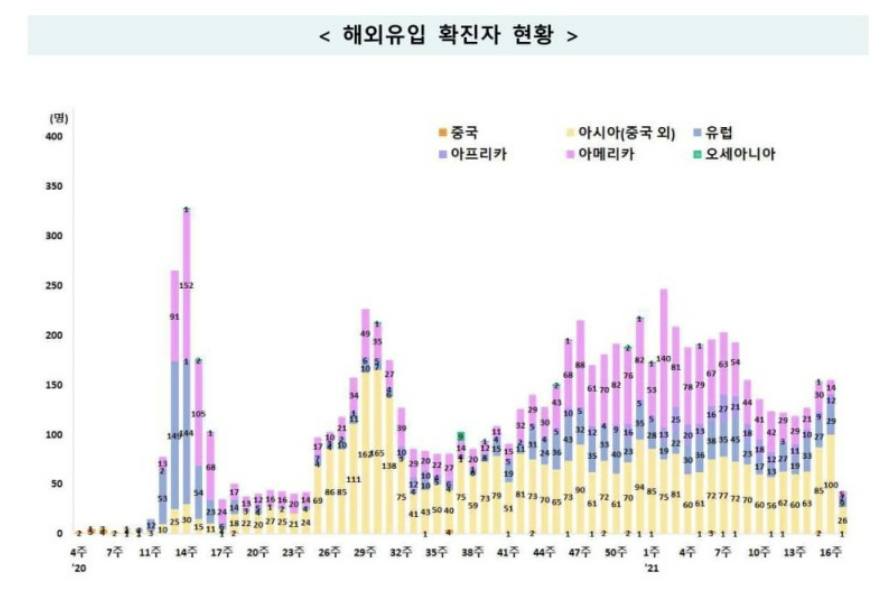

In [71]:
week_inf = es.search(index='covid_index_2',body={
    'query' : {
        'bool' : {
            'filter' : [{
                'range' : {
                    'corona19_date' : {
                        'gte' : '2020-02-01',
                        'lte' : '2021-04-31'
                    }
                }
            },
            {
                'term' : {
                    'corona19_contact_history.keyword' : '해외유입'
                }
            }]
        }
    },
    'size' : 0,
    'aggs' : {
        '주별 해외유입' : {
            'date_histogram' : {
                'field' : 'corona19_date',
                'interval' : 'week'
            }
        }
    }
})
week_inf

{'took': 4,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1071, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'주별 해외유입': {'buckets': [{'key_as_string': '2020-01-27T00:00:00.000Z',
     'key': 1580083200000,
     'doc_count': 1},
    {'key_as_string': '2020-02-03T00:00:00.000Z',
     'key': 1580688000000,
     'doc_count': 3},
    {'key_as_string': '2020-02-10T00:00:00.000Z',
     'key': 1581292800000,
     'doc_count': 0},
    {'key_as_string': '2020-02-17T00:00:00.000Z',
     'key': 1581897600000,
     'doc_count': 1},
    {'key_as_string': '2020-02-24T00:00:00.000Z',
     'key': 1582502400000,
     'doc_count': 4},
    {'key_as_string': '2020-03-02T00:00:00.000Z',
     'key': 1583107200000,
     'doc_count': 2},
    {'key_as_string': '2020-03-09T00:00:00.000Z',
     'key': 1583712000000,
     'doc_count': 8},
    {'key_as_string': '2020-03-16T00:00:00.000Z',
     'key': 1584316800000,

In [240]:
list = []
for week in week_inf['aggregations']['주별 해외유입']['buckets'] : 
    list.append(week)
df_weekly = pd.DataFrame(list)
df_weekly = df_weekly.drop(columns='key')
df_weekly['key_as_string'] = pd.to_datetime(df_weekly['key_as_string'])
df_weekly['week'] = df_weekly['key_as_string'].dt.week
df_weekly.head(16)

,key_as_string,doc_count,week
0,2020-01-27 00:00:00+00:00,1,5
1,2020-02-03 00:00:00+00:00,3,6
2,2020-02-10 00:00:00+00:00,0,7
3,2020-02-17 00:00:00+00:00,1,8
4,2020-02-24 00:00:00+00:00,4,9
5,2020-03-02 00:00:00+00:00,2,10
6,2020-03-09 00:00:00+00:00,8,11
7,2020-03-16 00:00:00+00:00,30,12
8,2020-03-23 00:00:00+00:00,68,13
9,2020-03-30 00:00:00+00:00,81,14


<AxesSubplot:xlabel='week', ylabel='doc_count'>

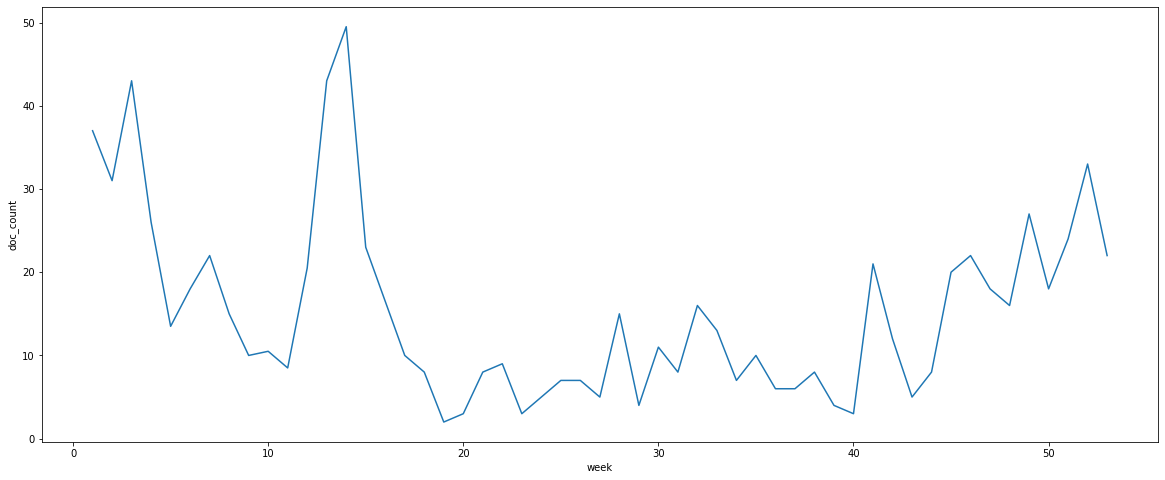

In [241]:
plt.figure(figsize=(20,8))
sns.lineplot(df_weekly['week'],df_weekly['doc_count'],ci=None)

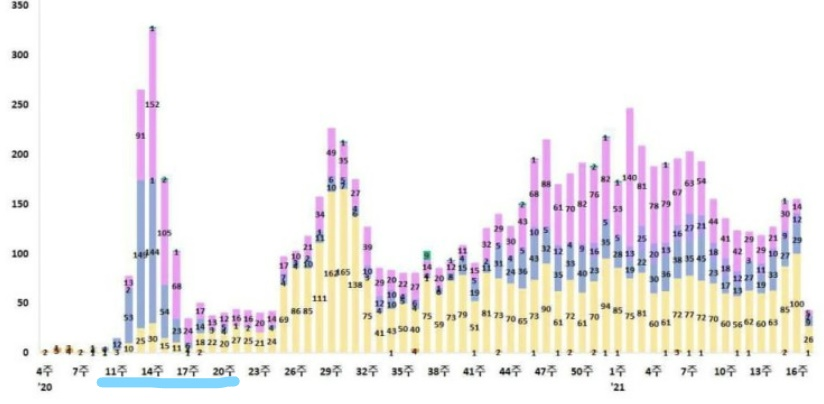

### 결론 : 11주(20년 3월 중순)~20주(20년 5월 중순) 사이 빼고는 다른 추이를 보였습니다.
### 서로 비슷한 양상을 보인 기간에 무슨일이 있었는지 확인 
* 해외교민(주로 미국 및 아시아 거주)들이 3월초부터 국내에 본격적으로 입국하기 시작
* 2월 중순까지는 해외여행이 가능 --> 여행객들이 국내로 복귀